# Example 1 - Simple Markov Chain

Here we'll use a simple two state markov chain with an absorbing state.

![Markov Decision Problem](../../assets/example_1.png)

The state and action spaces are:

$$ S = \{ \mathrm{S0}, \mathrm{S1} \}$$
$$ A = \{ \mathrm{A0}, \mathrm{A1} \}$$

Note that if we're in state S0, we can choose either A0 or A1. A0 has a half chance of leaving us in S0 and giving payoff 5, and a half chance of moving us to state S1 with payoff 5. A1 moves us directly to S1 and we get payoff 10.

When I'm in state S1, I can only choose action A1, which leaves me in S1 and gives -1 payoff.


Our transition and reward matrices are:

Action 0

$$ P_{0} = \begin{pmatrix} \frac{1}{2} & \frac{1}{2} \\ 0 & 0 \end{pmatrix} \quad R_{0} = \begin{pmatrix} 5 & 5 \\ 0 & 0 \end{pmatrix}$$

Action 1

$$ P_{0} = \begin{pmatrix} 0 & 1 \\ 0 & 1 \end{pmatrix} \quad R_{0} = \begin{pmatrix} 0 & 10 \\ 0 & -1 \end{pmatrix}$$


**Be aware of:**

The PyMDPToolbox package we use to solve the problems require that the transition matrices be valid Markov matrices (rows must sum to 1).

In this setup we are unable to choose action A0 if we're in state S1. So the transition matrix for this action has a row of 0s in the "current state = S1" row.

To fix this, we find rows that sum to 0; place a 1 on the diagonal elements; and replace the corresponding reward with a very negative number.

We should choose that negative number to be something smaller than the smallest payoff; like -1e-8. We can't set it to - $\infty$, because then after matrix multiplications everything will come out as infinities.

Our new transition and reward matrices are:


Action 0

$$ P_{0} = \begin{pmatrix} \frac{1}{2} & \frac{1}{2} \\ 0 & 1 \end{pmatrix} \quad R_{0} = \begin{pmatrix} 5 & 5 \\ 0 & -1e8 \end{pmatrix}$$

Action 1

$$ P_{0} = \begin{pmatrix} 0 & 1 \\ 0 & 1 \end{pmatrix} \quad R_{0} = \begin{pmatrix} 0 & 10 \\ 0 & -1 \end{pmatrix}$$


**Solution**

If this problem goes for one period, then the solution should be that we pick action A1 no matter what state we're in. If we're in state 1, A0 gives expected reward of 5; whereas A1 gives expected reward of 10. In state S1, we can only pick A1 which gives reward -1. So our policy and value functions for a one period problem are:

$$\mathrm{policy} = \begin{bmatrix} 1\\ 1 \end{bmatrix} \quad \mathrm{value}_{0} = \begin{bmatrix}10 \\ -1 \end{bmatrix}$$


If this is a two period problem, $t \in \{1, 0\}$, then the solution is

$$\mathrm{policy} = \begin{bmatrix} 0 & 1\\ 1 & 1 \end{bmatrix} \quad \mathrm{value}_{0} = \begin{bmatrix} 9.5 & 10 \\ -2 & -1 \end{bmatrix}$$


Let's verify that we get these solutions.

In [1]:
from rich import print
from rich.pretty import pprint

from markov_decision_process import TimeAugmentedMDP

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("deep")
%matplotlib inline

import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

#### Step 1: Set up problem


The class must be initialized with lists for S (state space), A (action space), and T (time intervals).

Define functions called `transition` and `reward`. These take the variables s_prime, s, t, a. (next state, current state, current time, action).

transition returns the transition probability for that event. reward returns the reward.

In [2]:
states: list[str] = ["S0", "S1"]
actions: list[str] = ["A0", "A1"]
times: list[int] = [-1, 0]


def transition(s_prime, s, a, t):
    if a == "A0":
        if s == "S0" and s_prime == "S0":
            return 0.5
        if s == "S0" and s_prime == "S1":
            return 0.5

    if a == "A1":
        if s == "S0" and s_prime == "S1":
            return 1
        if s == "S1" and s_prime == "S1":
            return 1

    return 0


def reward(s_prime, s, a, t):
    if a == "A0":
        if s == "S0" and s_prime == "S0":
            return 5
        if s == "S0" and s_prime == "S1":
            return 5

    if a == "A1":
        if s == "S0" and s_prime == "S1":
            return 10
        if s == "S1" and s_prime == "S1":
            return -1

    return -1e8

#### Step 2: Run the necessary functions

The class we're leveraging is TimeAugmentedMDP

It requires some inputs. Naturally:

- states: list[int] | list[float] | list[str]
- actions: list[int] | list[float] | list[str]
- times: list[int]

States and actions can be strings or numerics, but time must be increasing consecutive integers.


We need to specify a reward function that is a function of s_prime, s, a, t; exactly in that order with those variable names. 

We can provide a transition function, with the same arguments as the reward functions; but where the outputs are the probabilities of transitioning to state s_prime given we're in state s, time t, and take action a.

If we don't provide a transition function, we have to provide a model object with a predict_proba() method. We'll see an example of that later.


An interesting option is the `state_space_data_path` argument. This is for that massive cartesian product of states x states x actions x times. Since that can get large, and take up quite a bit of compute time; we compute it with Polars and write it as partitioned parquet to disk. If no argument is supplied, we use '/tmp/state_space_data/'. 

Passing the `force_overwrite` option deletes the previous data and reconstructs it. You'll need this if you tweak your state space/times/actions.

In [3]:
mdp = TimeAugmentedMDP(
    states=states,
    actions=actions,
    times=times,
    reward_function=reward,
    transition_function=transition,
    state_space_data_path="/tmp/state_space_data/",
    force_overwrite=True,
)

mdp.solve()

print("Policy:")
pprint(mdp.policy_function, expand_all=True)

print("Value Function:")
pprint(mdp.value_function, expand_all=True)

INFO:markov_decision_process.time_augmented_mdp:Mode not set. Inferring mode...
INFO:markov_decision_process.time_augmented_mdp:Reward function is vectorized: False
INFO:markov_decision_process.time_augmented_mdp:Transition function is vectorized: False
INFO:markov_decision_process.time_augmented_mdp:Reward and transition functions are not vectorized. Setting mode to "flexible"
INFO:markov_decision_process.time_augmented_mdp:State space augmented with time
INFO:markov_decision_process.time_augmented_mdp:Generating state space data...
INFO:markov_decision_process.time_augmented_mdp:No data found on disk. Generating...
INFO:markov_decision_process.time_augmented_mdp:State space data generated and saved to disk
INFO:markov_decision_process.time_augmented_mdp:Generating rewards and transitions...
INFO:markov_decision_process.time_augmented_mdp:MDP solved


Policy:

{
│   -1: {
│   │   'S0': 'A0',
│   │   'S1': 'A1'
│   },
│   0: {
│   │   'S0': 'A1',
│   │   'S1': 'A1'
│   }
}

Value Function:

{
│   -1: {
│   │   'S0': 9.5,
│   │   'S1': -2.0
│   },
│   0: {
│   │   'S0': 10.0,
│   │   'S1': -1.0
│   }
}

### Plot the transition matrices

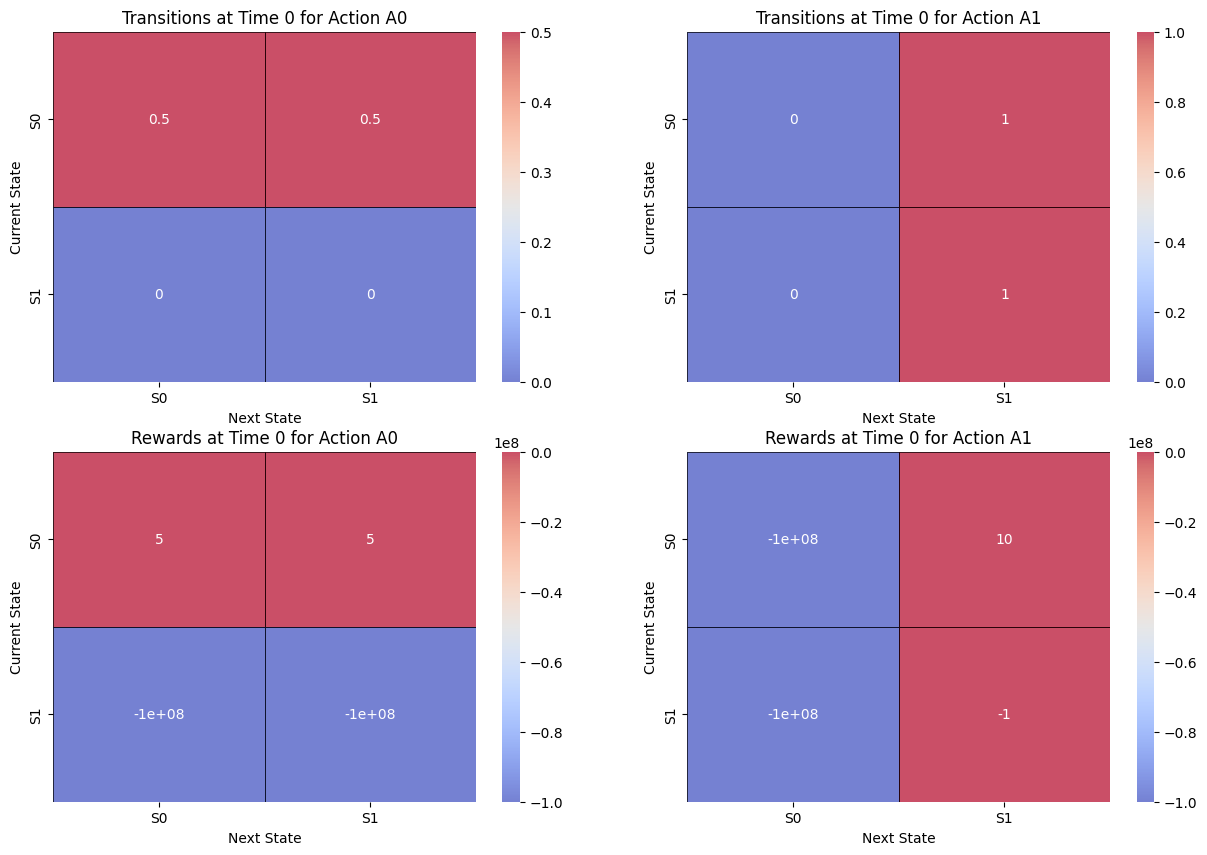

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Plot the transition matrix for actions A1 and A2
mdp.plot_matrix(
    matrix_type="transitions", t=0, a="A0", ax=ax[0, 0], annotate=True
)
mdp.plot_matrix(
    matrix_type="transitions", t=0, a="A1", ax=ax[0, 1], annotate=True
)
mdp.plot_matrix(matrix_type="rewards", t=0, a="A0", ax=ax[1, 0], annotate=True)
mdp.plot_matrix(matrix_type="rewards", t=0, a="A1", ax=ax[1, 1], annotate=True)

plt.show()

Easy, right?